In [1]:
using JLD, KernelDensity
using PyCall, PyPlot

addprocs(10)
using Gync

@pyimport seaborn as sns

In [2]:
sns.set_style("whitegrid")
PyPlot.matplotlib[:rc]("savefig", dpi=300)

fac20err10 = ["../out/fac20err10/$(p)_$c.jld" for p in 1:3, c in 1:3]
fac5err5   = ["../out/fac5err5/$(p)_$c.jld"   for p in 1:5, c in 1:3]
fac5err10  = ["../out/fac5err10/$(p)_$c.jld"  for p in 1:5, c in 1:3]
fac3err5   = ["../out/fac3err5/pfizer$p.jld"  for p in 1:13]
lausaunne  = filter(isfile, ["../out/fac5err10/lausanne$p.jld" for p in 1:45])

files = lausaunne

commonlength = minimum([jldopen(file->size(file["chains"],1), f, "r") for f in files])

chain = Gync.MergedChain{Float64}(Vector{Matrix{Float64}}(
    [load(f)["chains"][1:5_000:commonlength, :, 1] for f in files]));
@show size(chain)

println("expected computation time (h): ", size(chain,1)*length(files)/30/60/60/length(workers()))

size(chain) = (780,115)
expected computation time (h): 0.0

In [7]:
datas = Matrix[Gync.data(load(f)["subj"]) for f in files];
@time lhs = Gync.likelihoods(chain[1,:], datas[[1]], 5)

1x1 SharedArray{Float64,2}:
 0.157048

2.701708 seconds (30.80 k allocations: 1.584 MB)


In [18]:
reload("Gync")
Gync.likelihood(datas[1], chain[1,:]|>vec, 5)

0.1570479473435726

In [17]:
reload("Gync")
Gync.likelihood(datas[1], chain[1,:]|>vec, 5)

0.1570479473435725

In [23]:
reload("Gync")
Gync.likelihood(datas[1], chain[1,:]|>vec, 5)

0.1570479473435726

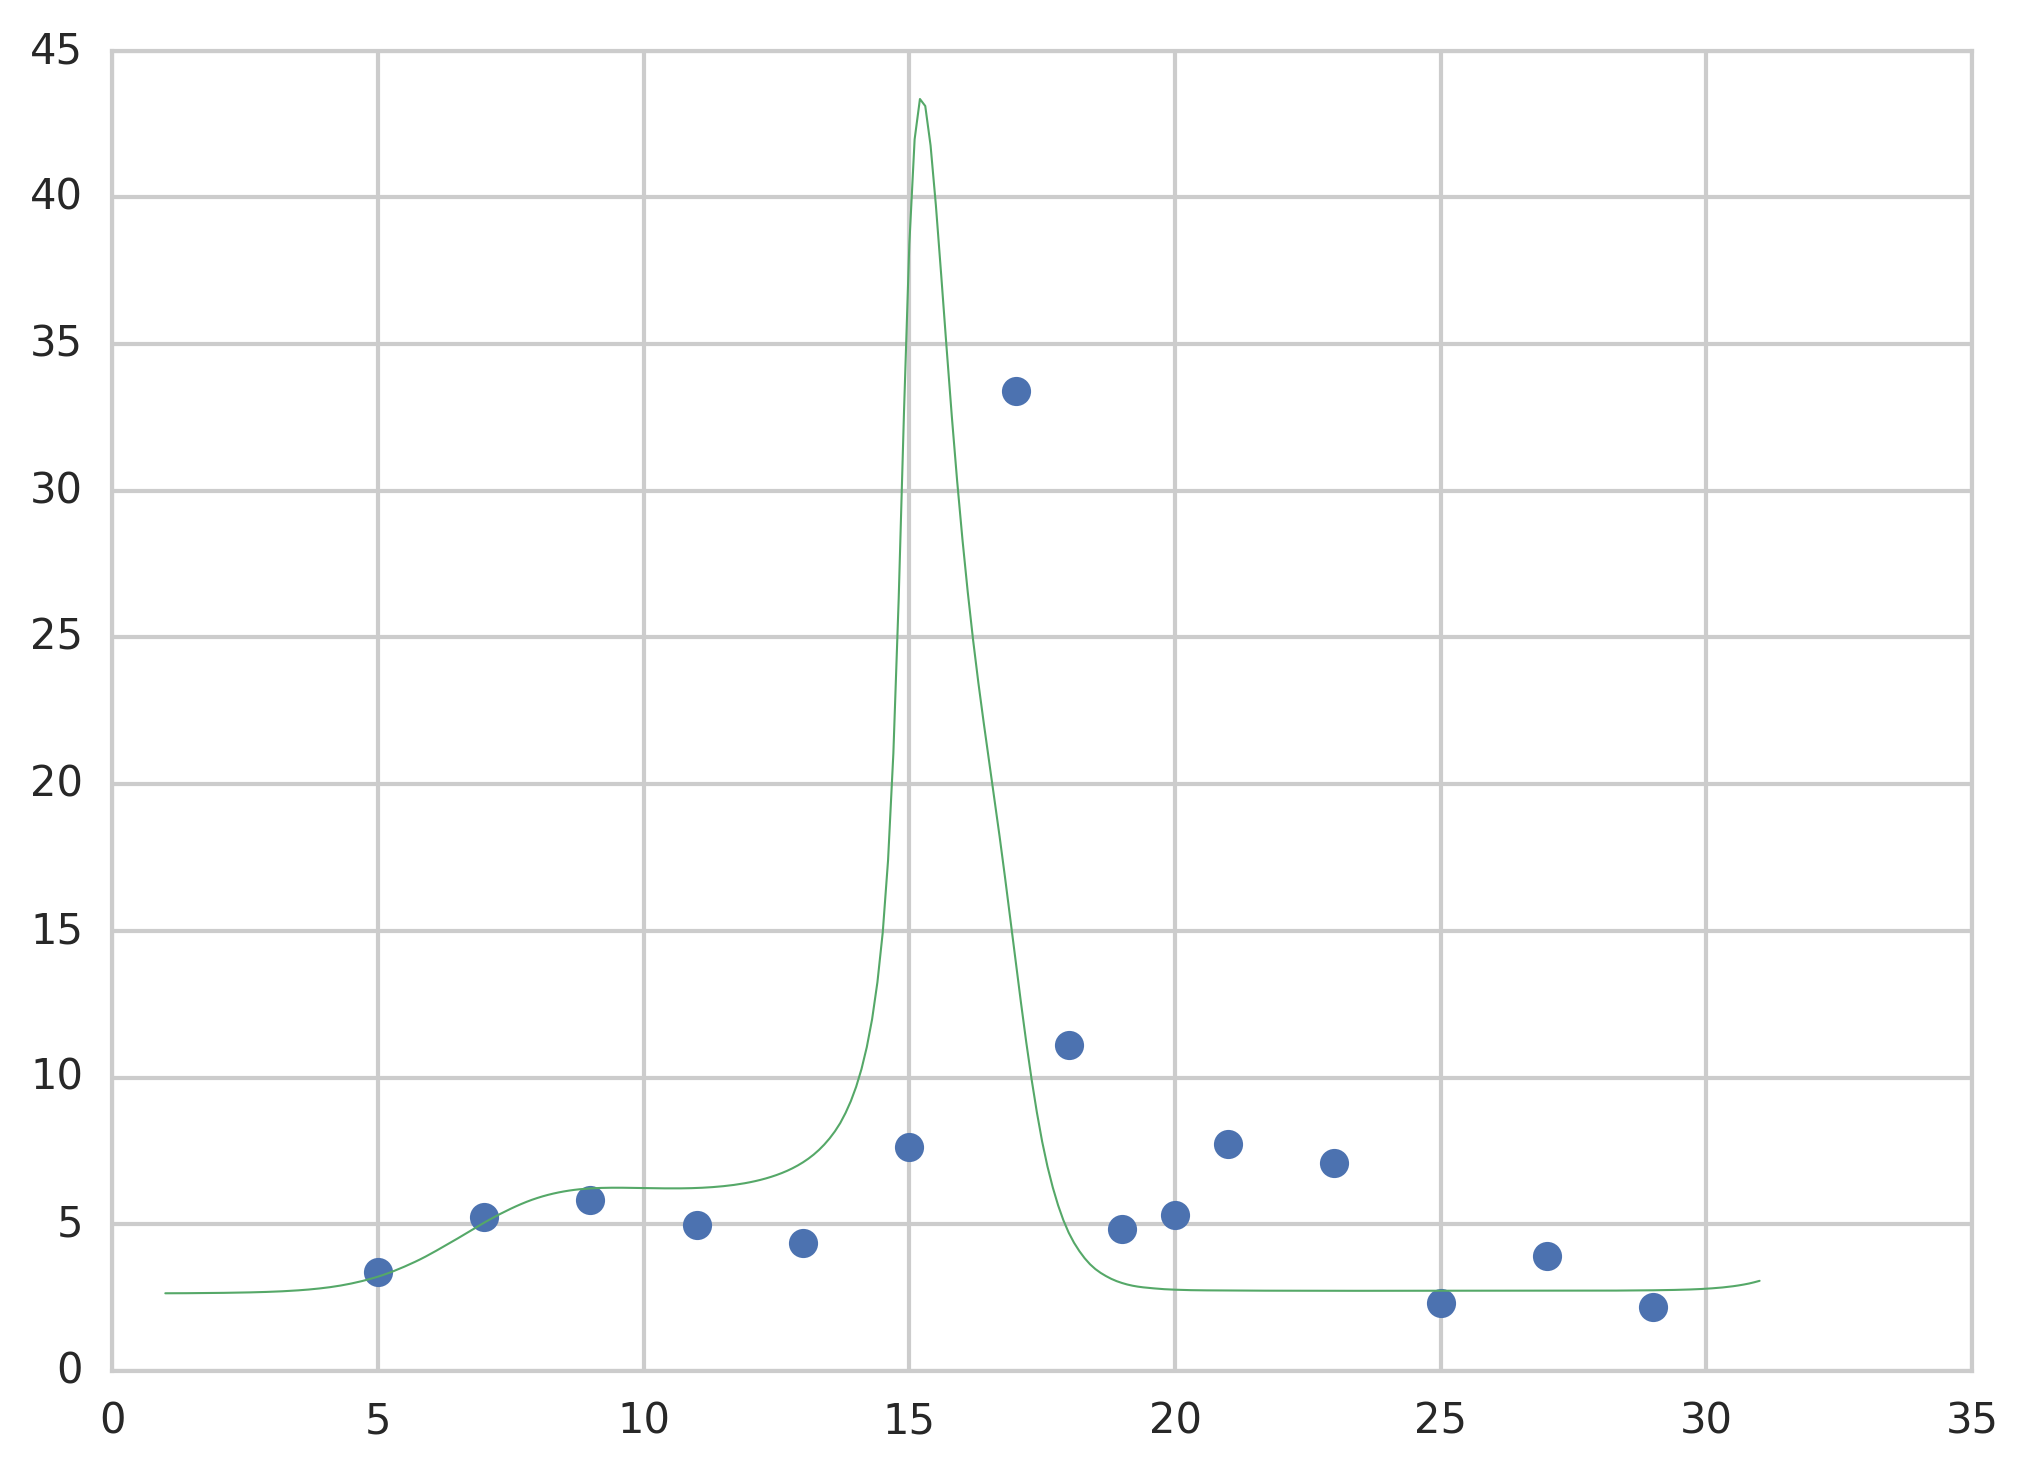

In [22]:
compare(1, datas[[1]], chain[1,:])

In [28]:
datas = Matrix[Gync.data(load(f)["subj"]) for f in files];
@time lhs = Gync.likelihoods(chain, datas, 10)

109.

780x39 SharedArray{Float64,2}:
 0.629518     0.525983     0.437944      …  0.694438      0.81653     
 5.64163e-5   7.58356e-5   1.97014e-6       4.7661e-26    0.00684396  
 1.27474e-6   3.14179e-7   2.62337e-8       4.01342e-33   0.000390777 
 2.13564e-42  1.45613e-17  1.71614e-17      3.26011e-28   5.17282e-14 
 1.91642e-47  1.72859e-43  4.27687e-58      3.09071e-253  6.07004e-25 
 1.86897e-5   0.000629229  5.02998e-5    …  2.77025e-18   0.00662909  
 9.07942e-26  3.50953e-24  1.54226e-31      2.3877e-132   2.50531e-12 
 4.27512e-19  1.61326e-9   2.45589e-27      2.60432e-67   2.76589e-17 
 0.0          0.0          0.0              0.0           0.0         
 0.0030545    0.00426035   0.000666039      3.43303e-15   0.0360295   
 2.8667e-14   1.89375e-6   4.41603e-12   …  1.04593e-14   7.63339e-7  
 1.52563e-48  6.90636e-24  1.10144e-50      1.01479e-88   2.48383e-48 
 0.00197339   0.000881489  0.00034326       4.372e-8      0.000432107 
 ⋮                                       ⋱    

764910 seconds (44.12 k allocations: 10.338 MB)


In [21]:
using PyPlot

function plotsolution(sample::Vector, species::Int; kwargs...)
    sample = sample
    parms = copy(Gync.mleparms)
    parms[Gync.sampleparms] = sample[1:82]
    y0 = sample[83:115]
    t = Array{Float64}(collect(1:1/10:31))
    y = Gync.gync(y0, t, parms)[species,:] |> vec
    PyPlot.plot(t,y; kwargs...)
end

function plotdata(datas::Vector{Matrix}, species::Int=1; kwargs...)
    map(datas) do data
        PyPlot.plot(collect(1:31), data[species,:] |> vec, "o", linewidth=.5; kwargs...)
    end
end

function compare(measurement=1, datas=datas, samples=chain[1,:])
    figure()
    species = Gync.MEASURED[measurement]

    plotdata(datas, measurement)
    
    for i = 1:size(samples,1)
        plotsolution(samples[i,:] |> vec, species, linewidth=.5)
    end
    display()
end

compare (generic function with 4 methods)

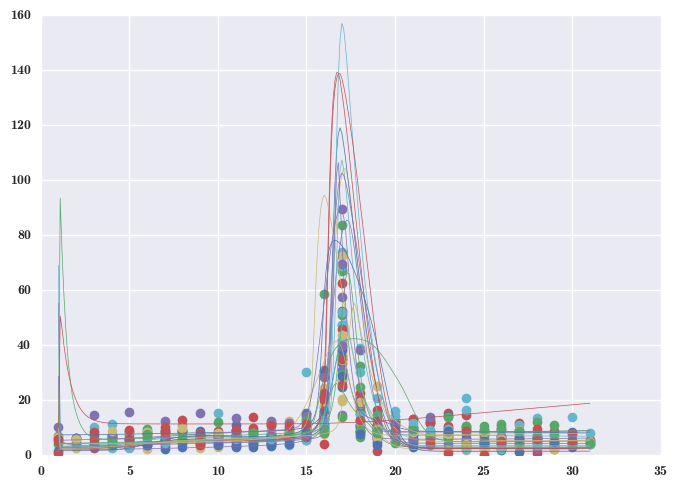

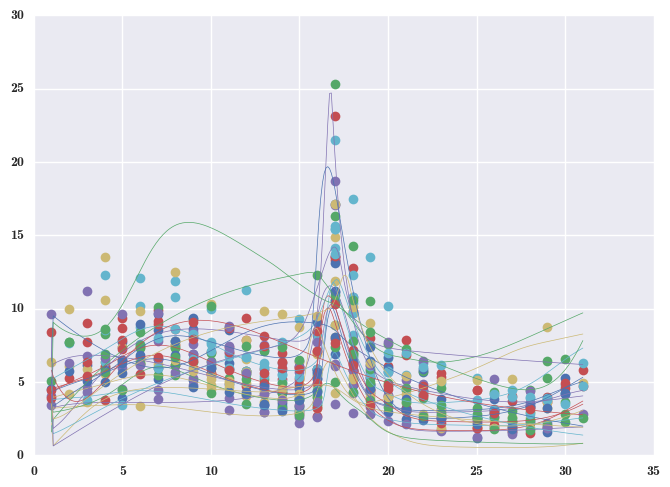

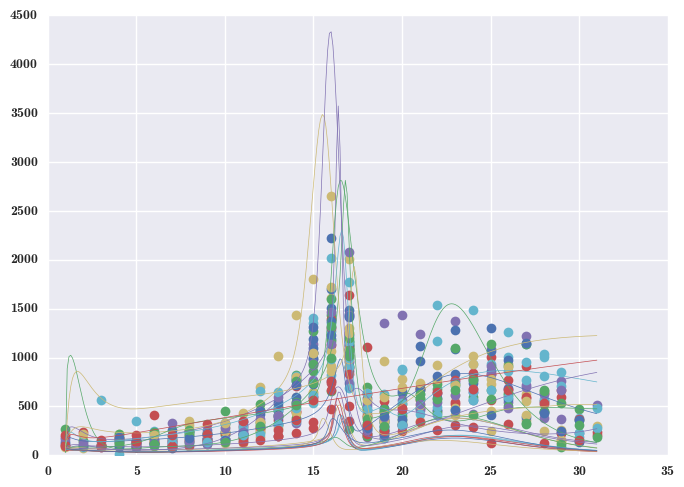

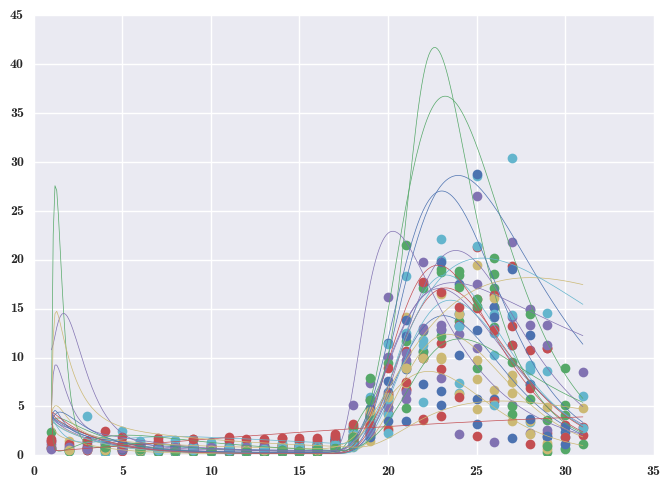

/datanumerik/bzfsikor/julia/pkg/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/datanumerik/bzfsikor/julia/pkg/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1298: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=400:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


In [3]:
for i=1:4
    compare(i)
end

In [4]:
denssamples(wc, spec, samples=10*size(wc.chain,1)) = vcat(map(i->fill(wc.chain[i,spec], round(Int,wc.weights[i]*samples)),1:size(wc.chain,1))...)

function kdeplot(data; kwargs...)
    k = kde(data)
    PyPlot.plot(k.x, k.density; kwargs...)
end

function rescalelh(wc, sigmafactor)
    nwc = deepcopy(wc)
    nwc.likelihoods = map(x->exp(log(x)/(sigmafactor^2)), nwc.likelihoods)
    nwc
end

rescalelh (generic function with 1 method)

In [8]:
plot([1,2,3],[4,5,5])
display()

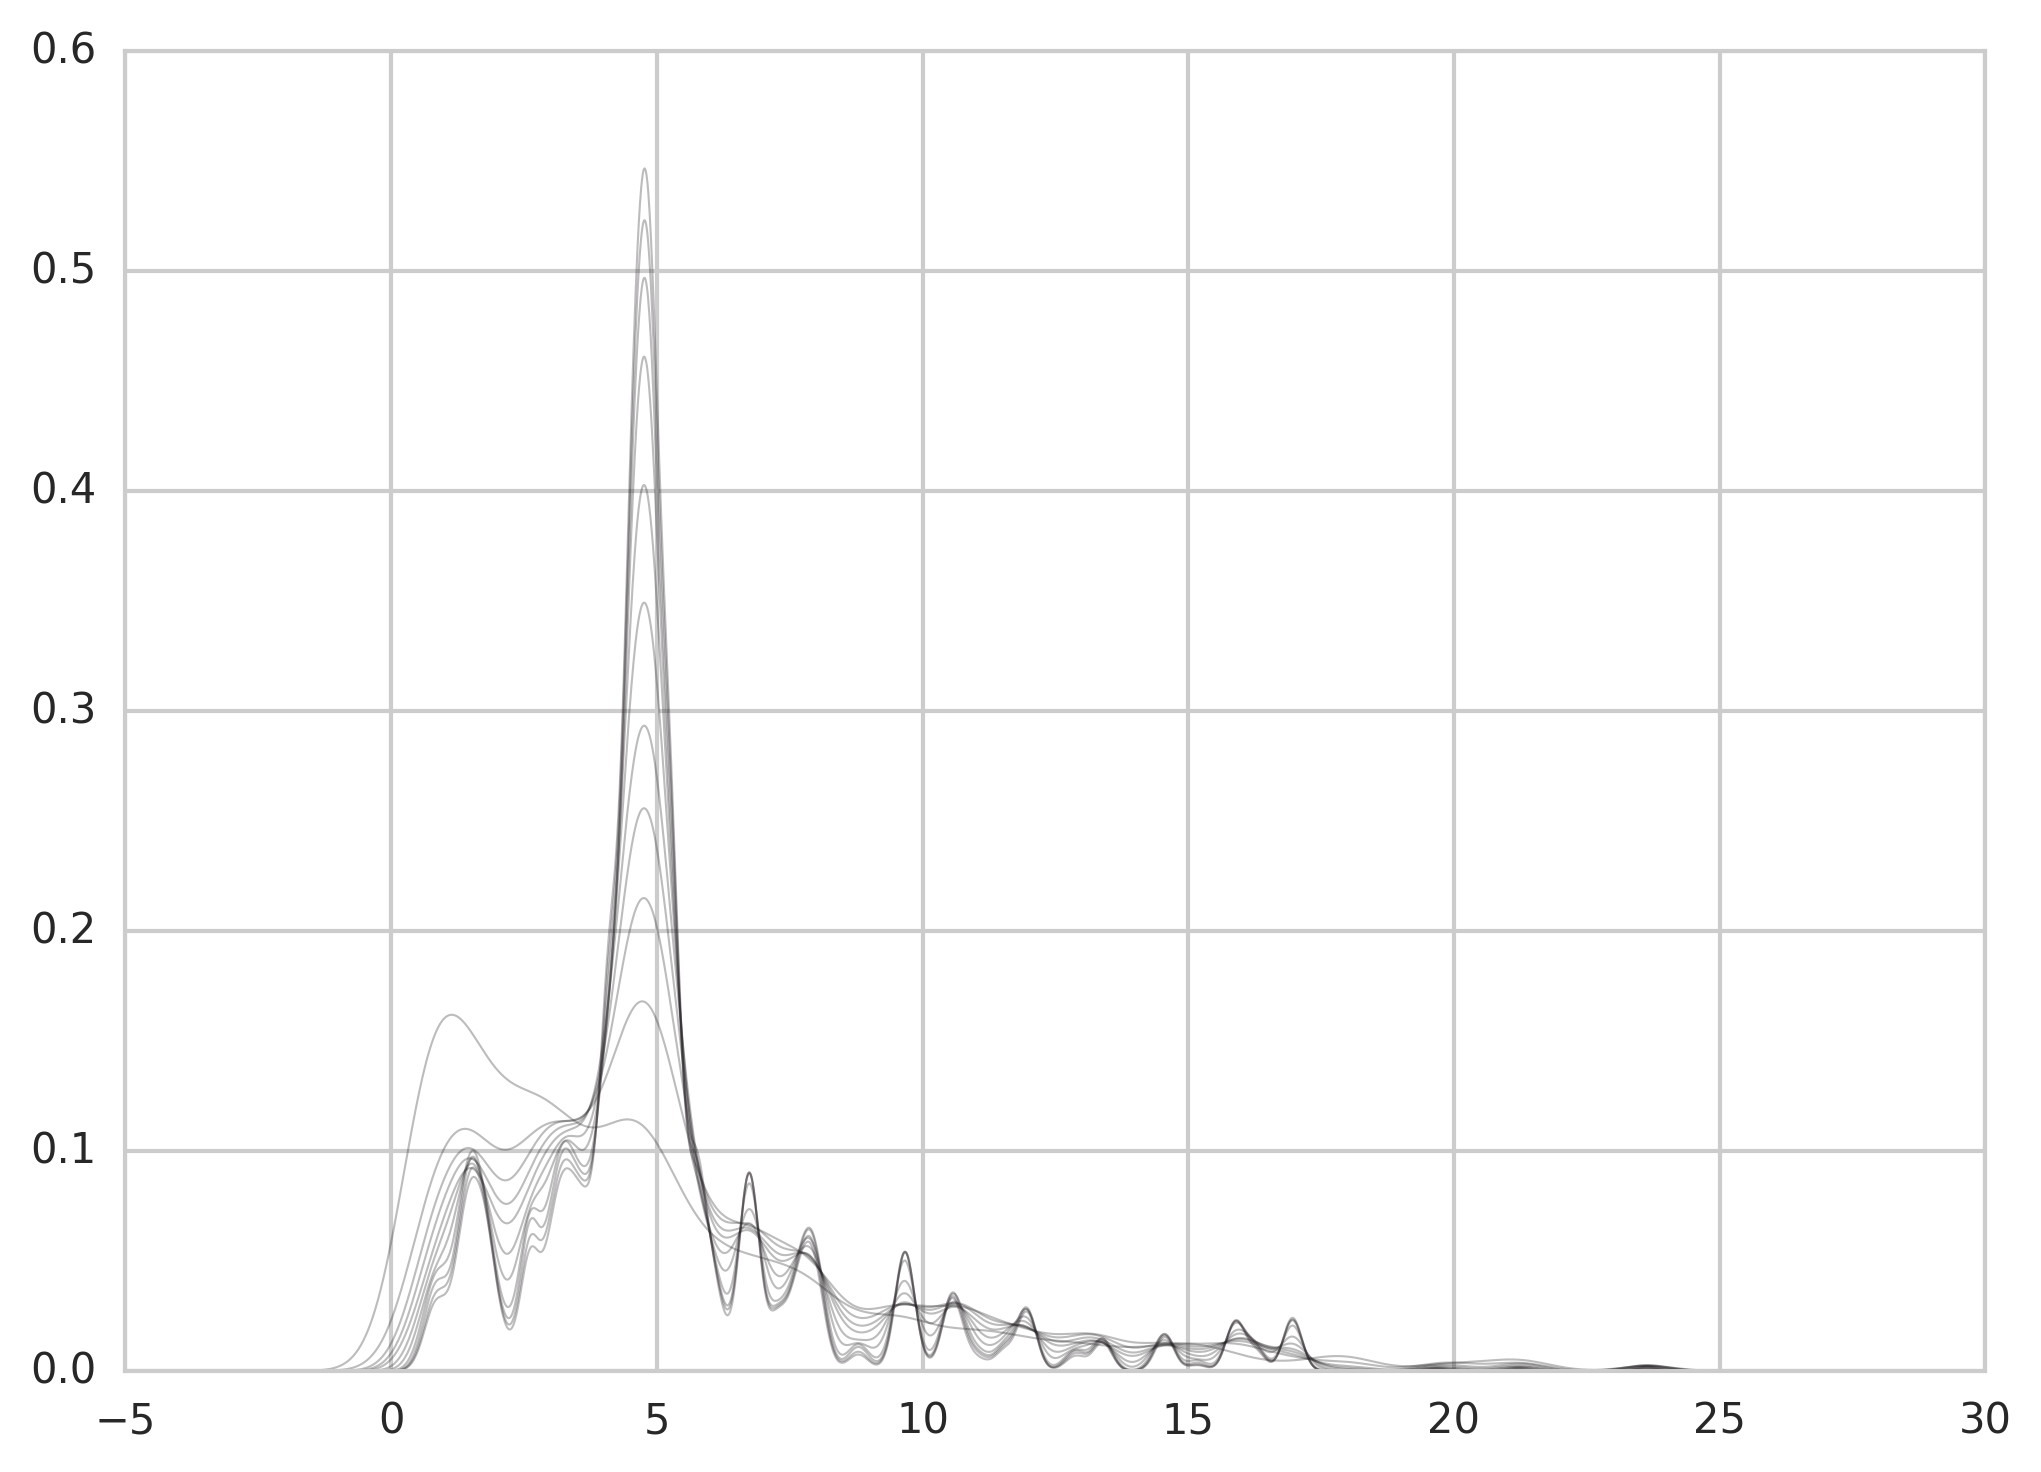

3.775932 seconds (5.14 M allocations: 120.948 MB, 2.69% gc time)


In [26]:
K = size(chain, 1)
wc = Gync.WeightedChain(chain, ones(K)/K, lhs);
wc = rescalelh(wc, 10)


@time for i=0:10
    k = kde(denssamples(wc,8))
    #i % 5 == 0 && 
    PyPlot.plot(k.x, k.density, linewidth=0.5, alpha=0.3)
    Gync.reweight!(wc);    
end


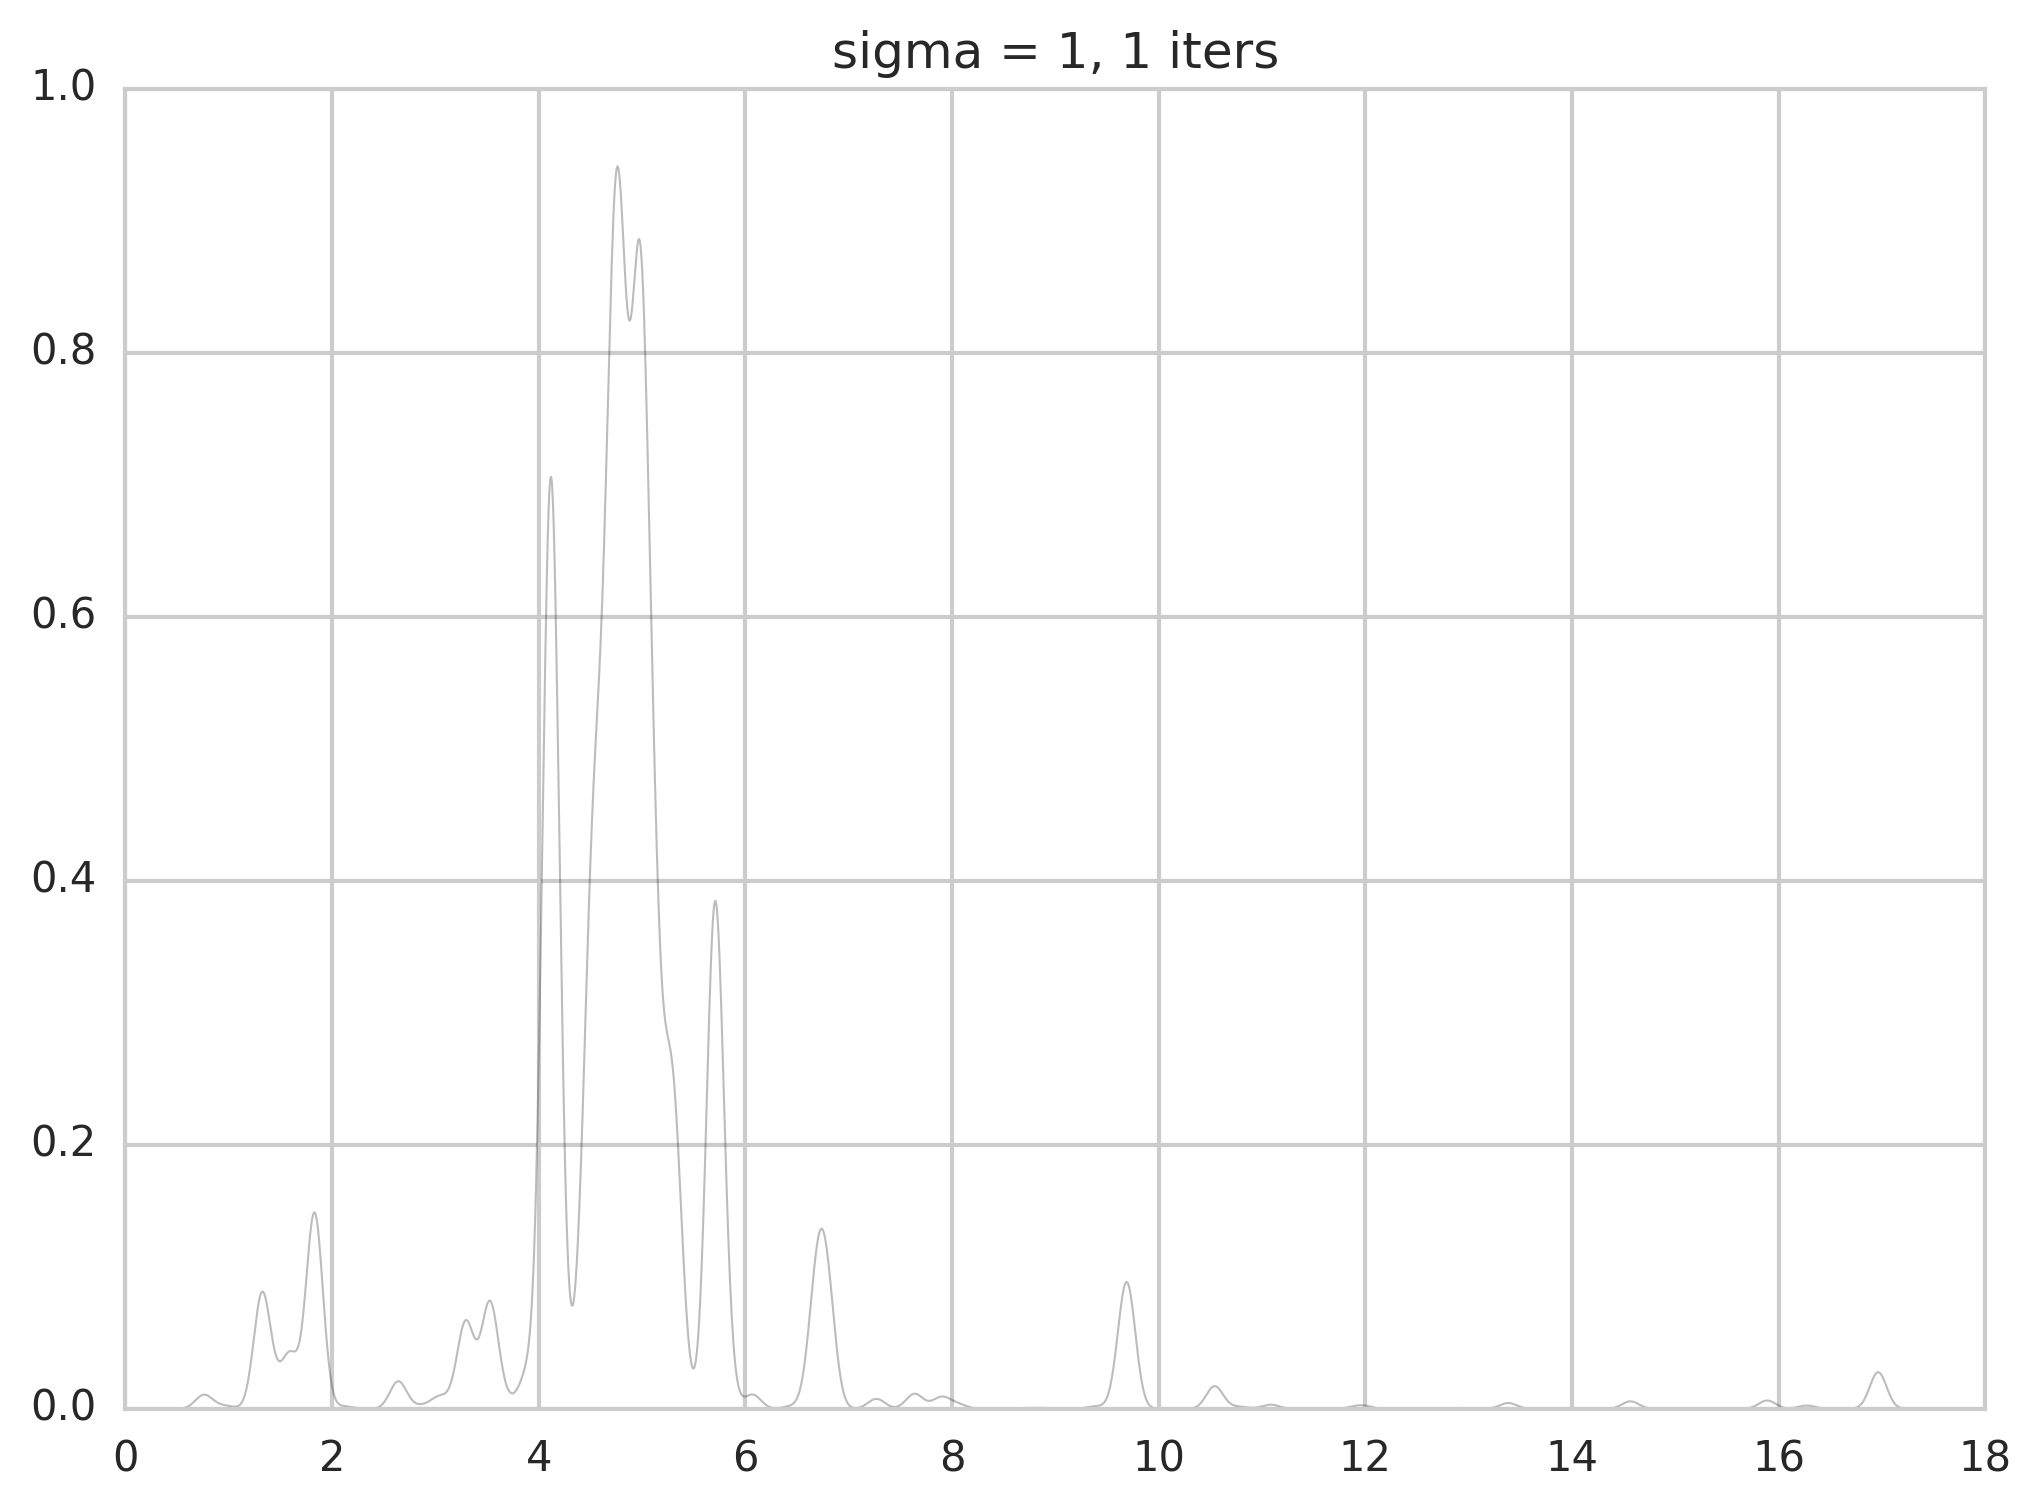

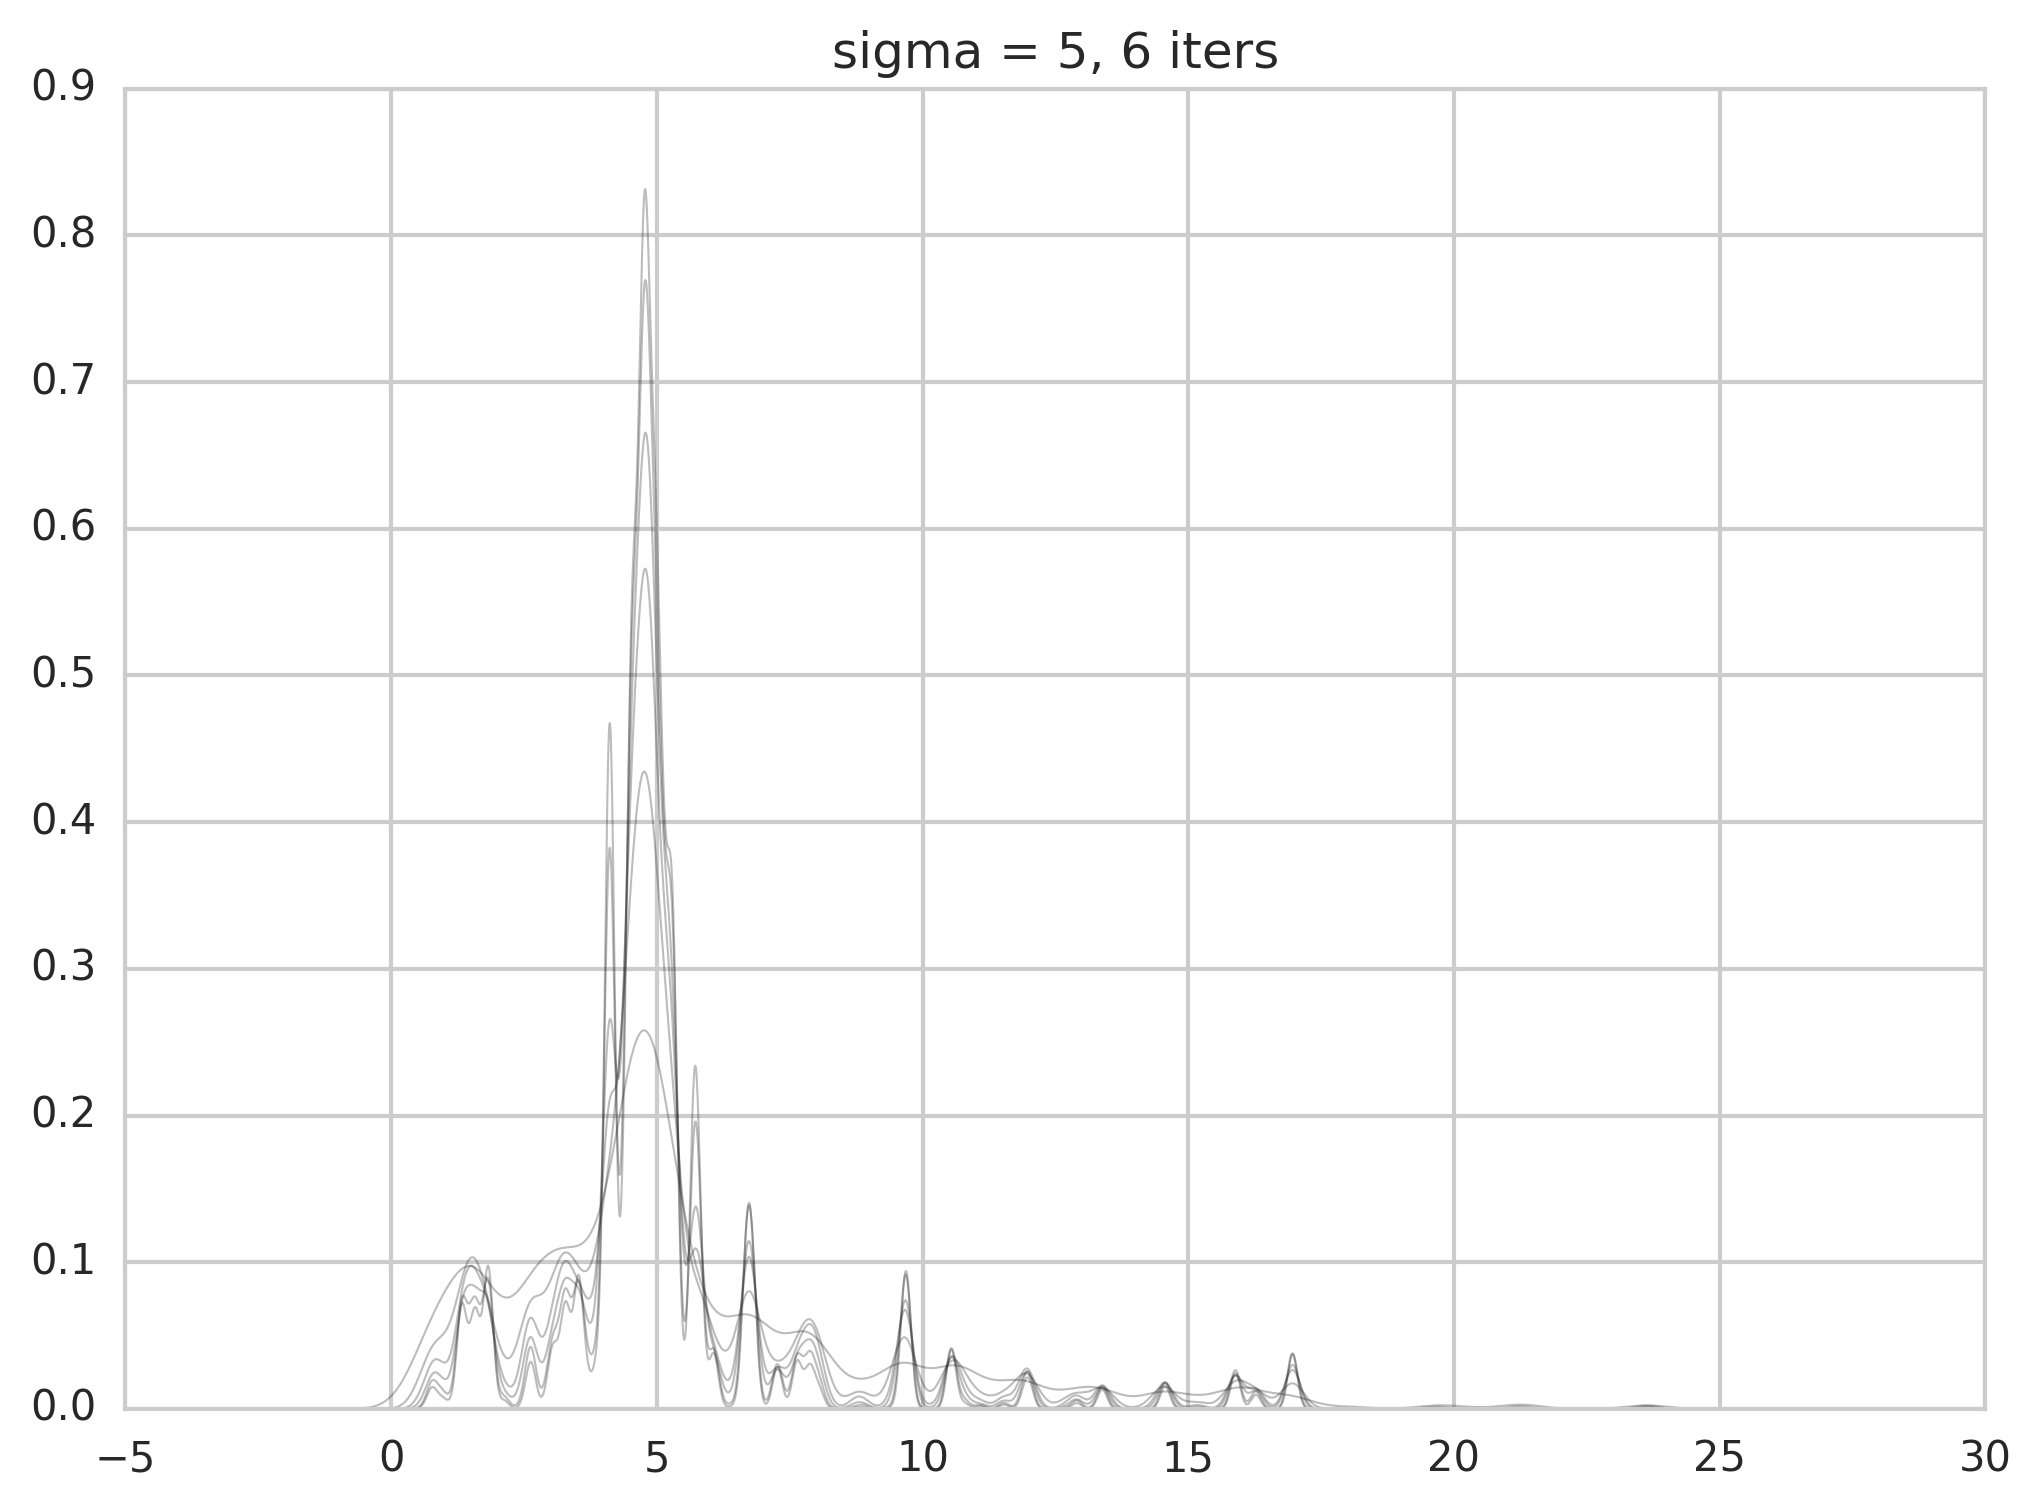

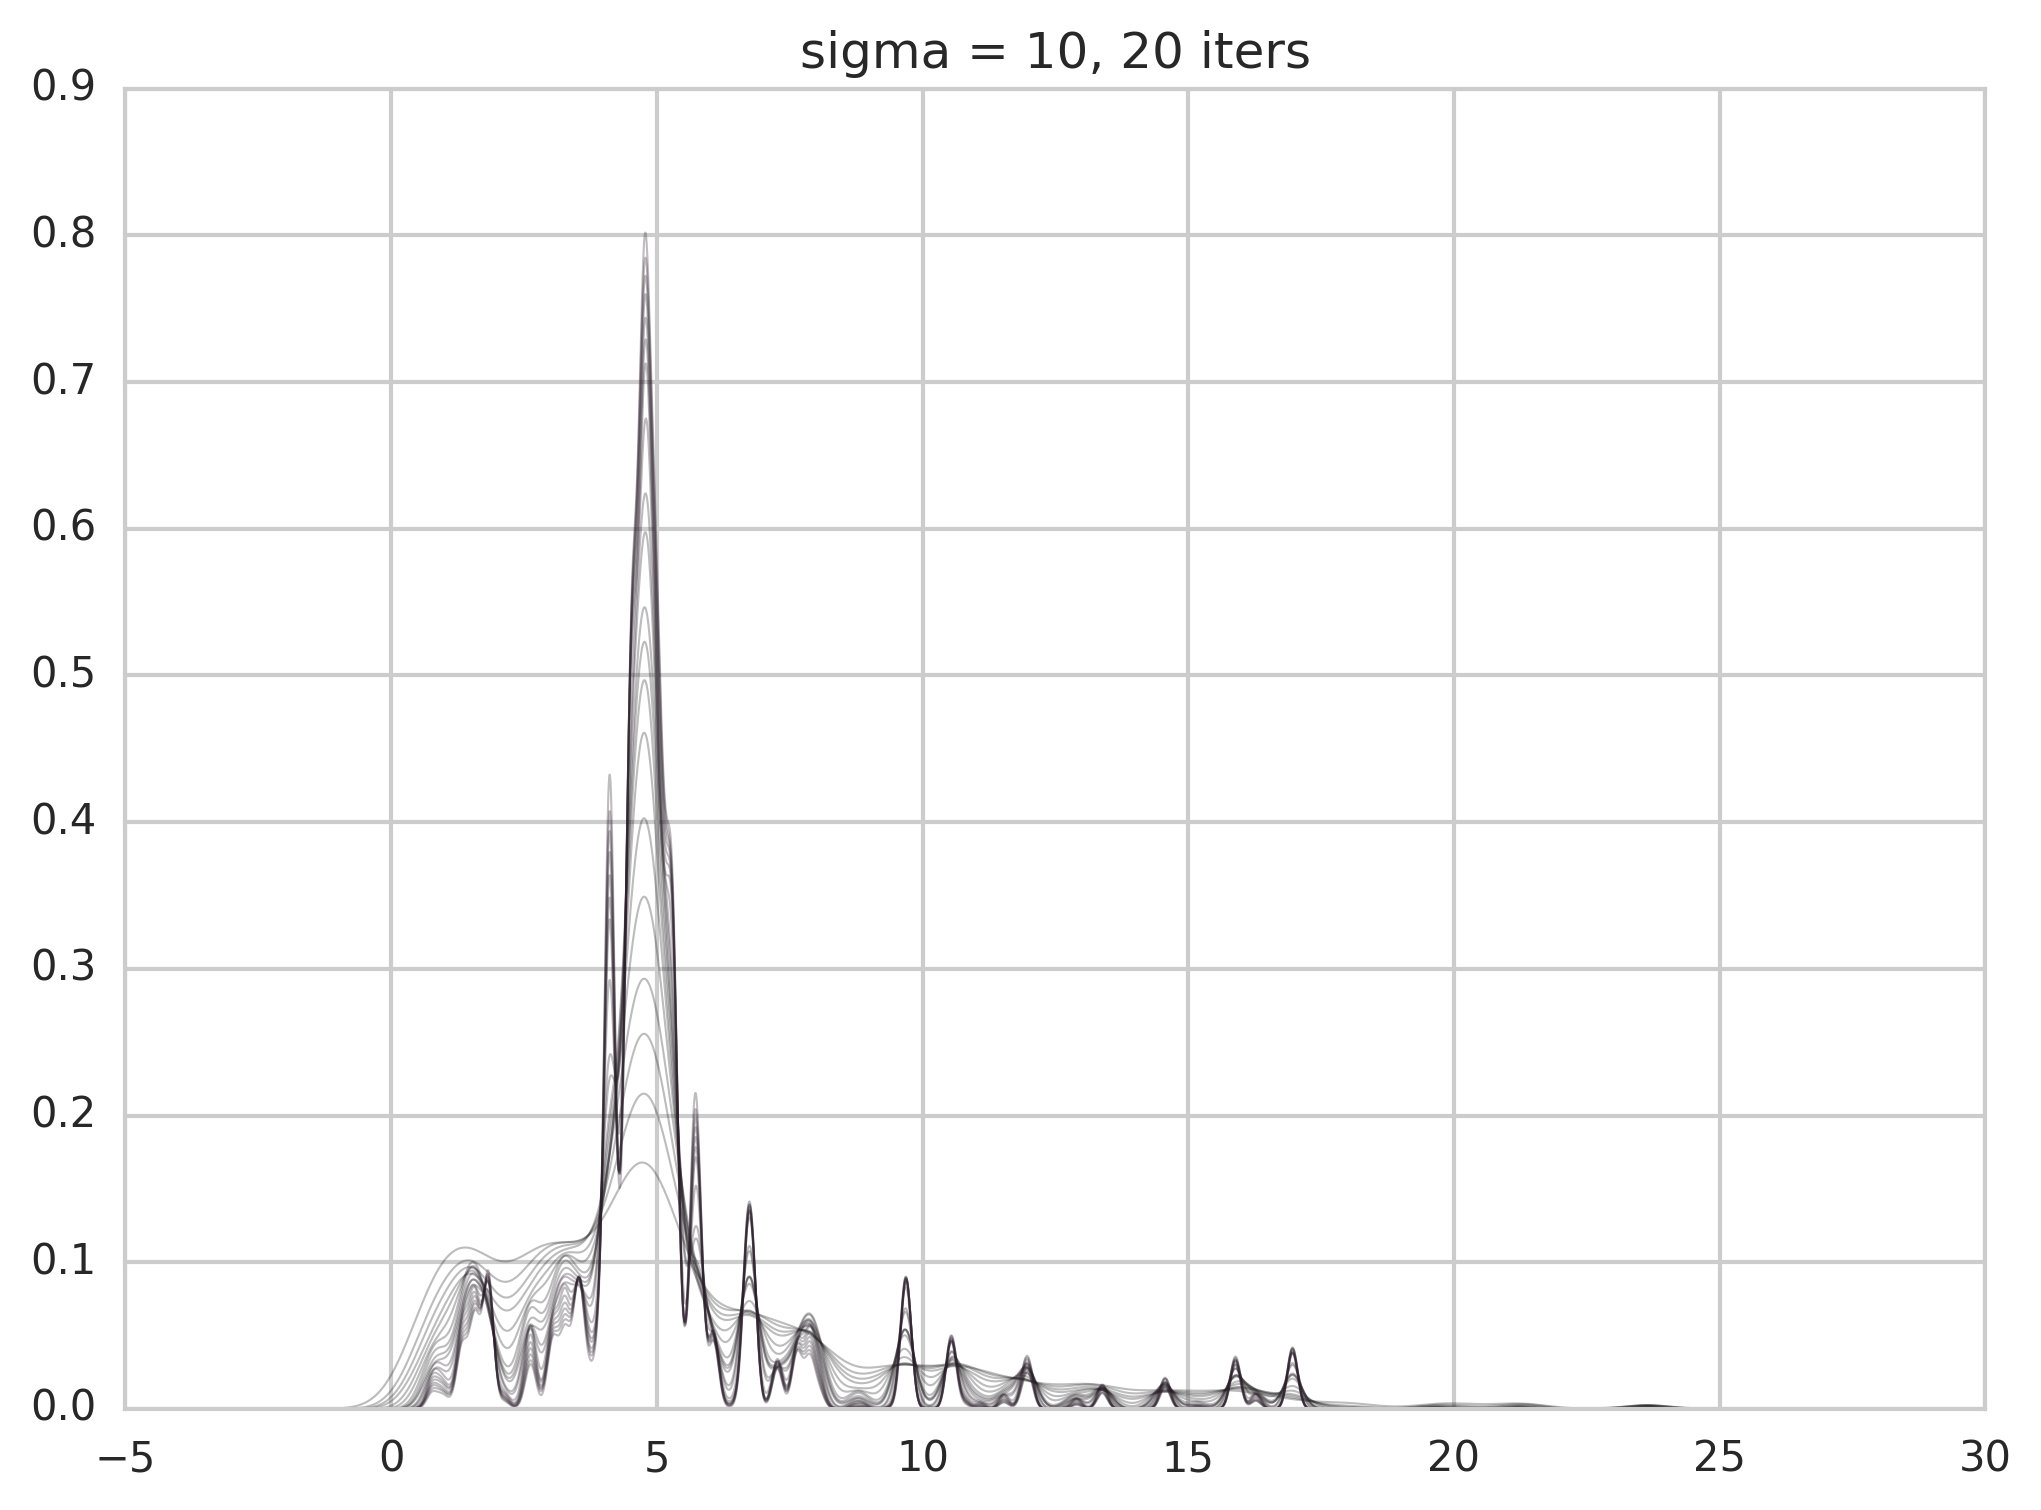

LoadError: LoadError: InterruptException:
while loading In[12], in expression starting on line 5

In [12]:
sns.set_style("whitegrid")
PyPlot.matplotlib[:rc]("savefig", dpi=300)
PyPlot.ion()

for sigma in [1, 5, 10, 30, 50]
    figure()
    
    
    K = size(chain, 1)
    wc = Gync.WeightedChain(chain, ones(K)/K, lhs);
    wc = rescalelh(wc, sigma)

    maxiters = 500

    sns.set_palette(sns.dark_palette("purple",180))

    for i=1:maxiters 
        k = kde(denssamples(wc,8))
        (i < 100 || i%5==0 ) && PyPlot.plot(k.x, k.density, linewidth=0.5, alpha=0.3)  
        Gync.reweight!(wc)
        title("\sigma = $sigma, $i iters")
        maximum(k.density) > 0.8 && break
    end
    display()
end

In [10]:
wc = Gync.WeightedChain(chain, ones(K)/K, lhs);
k = kde(denssamples(wc,8))
PyPlot.plot(k.x, k.density)

LoadError: LoadError: UndefVarError: K not defined
while loading In[10], in expression starting on line 1

In [40]:
display(sort(wc.weights, rev=true)[1:10])
topinds = sortperm(wc.weights, rev=true)[1:10]
display(wc.chain[topinds,8])
display(wc.likelihoods[topinds,:])

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 -25 
 -24 
 -23 
 -22 
 -21 
 -20 
 -19 
 -18 
 -17 
 -16 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 -40 
 -20 
 0 
 20 
 40 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M42.35,78.69 L 42.61 78.68 42.88 78.67 43.14 78.66 43.41 78.64 43.67 78.62 43.94 78.58 44.2 78.54 44.47 78.49 44.73 78.43 45 78.34 45.26 78.24 45.53 78.11 45.79 77.95 46.06 77.76 46.32 77.52 46.58 77.23 46.85 76.88 47.11 76.46 47.38 75.97 47.64 75.39 47.91 74.7 48.17 73.91 48.44 72.99 48.7 71.94 48.97 70.75 49.23 69.4 49.5 67.88 49.76 66.19 50.03 64.33 50.29 62.29 50.56 60.07 50.82 57.68 51.09 55.12 51.35 52.41 51.62 49.56 51.88 46.59 52.15 43.54 52.41 40.42 52.68 37.27 52.94 34.14 53.21 31.05 53.47 28.05 53.73 25.18 54 22.49 54.26 20.02 54.53 17.8 54.79 15.87 55.06 14.26 55.32 13.01 55.59 12.13 55.85 11.64 56.12 11.55 56.38 11.85 56.65 12.55 56.91 13.62 57.18 15.05 57.44 16.81 57.71 18.87 57.97 21.19 58.24 23.74 58.5 26.46 58.77 29.32 59.03 32.27 59.3 35.28 59.56 38.28 59.83 41.26 60.09 44.16 60.36 46.96 60.62 49.63 60.88 52.15 61.15 54.48 61.41 56.64 61.68 58.59 61.94 60.34 62.21 61.88 62.47 63.22 62.74 64.37 63 65.33 63.27 66.12 63.53 66.74 63.8 67.23 64.06 67.59 64.33 67.83 64.59 67.99 64.86 68.07 65.12 68.1 65.39 68.09 65.65 68.05 65.92 68.01 66.18 67.97 66.45 67.94 66.71 67.94 66.98 67.97 67.24 68.04 67.5 68.15 67.77 68.31 68.03 68.51 68.3 68.76 68.56 69.06 68.83 69.4 69.09 69.78 69.36 70.18 69.62 70.62 69.89 71.08 70.15 71.55 70.42 72.03 70.68 72.52 70.95 73 71.21 73.47 71.48 73.92 71.74 74.36 72.01 74.77 72.27 75.16 72.54 75.51 72.8 75.83 73.07 76.11 73.33 76.35 73.6 76.55 73.86 76.71 74.13 76.81 74.39 76.87 74.65 76.87 74.92 76.81 75.18 76.69 75.45 76.5 75.71 76.25 75.98 75.91 76.24 75.49 76.51 74.98 76.77 74.38 77.04 73.67 77.3 72.86 77.57 71.93 77.83 70.88 78.1 69.71 78.36 68.42 78.63 67 78.89 65.46 79.16 63.81 79.42 62.04 79.69 60.17 79.95 58.21 80.22 56.17 80.48 54.08 80.75 51.96 81.01 49.83 81.28 47.71 81.54 45.64 81.8 43.63 82.07 41.73 82.33 39.95 82.6 38.34 82.86 36.9 83.13 35.68 83.39 34.68 83.66 33.92 83.92 33.43 84.19 33.2 84.45 33.24 84.72 33.56 84.98 34.13 85.25 34.97 85.51 36.04 85.78 37.34 86.04 38.83 86.31 40.5 86.57 42.32 86.84 44.26 87.1 46.29 87.37 48.38 87.63 50.51 87.9 52.64 88.16 54.75 88.43 56.82 88.69 58.83 88.95 60.76 89.22 62.6 89.48 64.33 89.75 65.94 90.01 67.43 90.28 68.8 90.54 70.04 90.81 71.16 91.07 72.15 91.34 73.02 91.6 73.77 91.87 74.4 92.13 74.93 92.4 75.36 92.66 75.68 92.93 75.91 93.19 76.05 93.46 76.1 93.72 76.06 93.99 75.94 94.25 75.73 94.52 75.44 94.78 75.06 95.05 74.59 95.31 74.04 95.57 73.38 95.84 72.64 96.1 71.79 96.37 70.84 96.63 69.78 96.9 68.61 97.16 67.33 97.43 65.94 97.69 64.43 97.96 62.81 98.22 61.07 98.49 59.22 98.75 57.25 99.02 55.18 99.28 53 99.55 50.73 99.81 48.37 100.08 45.94 100.34 43.44 100.61 40.88 100.87 38.29 101.14 35.69 101.4 33.08 101.67 30.5 101.93 27.97 102.2 25.51 102.46 23.15 102.72 20.91 102.99 18.83 103.25 16.93 103.52 15.24 103.78 13.78 104.05 12.57 104.31 11.65 104.58 11.01 104.84 10.69 105.11 10.69 105.37 11.01 105.64 11.66 105.9 12.63 106.17 13.91 106.43 15.49 106.7 17.34 106.96 19.46 107.23 21.79 107.49 24.33 107.76 27.03 108.

10-element Array{Float64,1}:
 0.335383  
 0.290532  
 0.227644  
 0.09291   
 0.0517643 
 0.00163   
 0.0001154 
 2.05591e-5
 3.52536e-7
 1.06396e-7

10-element Array{Float64,1}:
  1.90665
 10.1924 
  6.62384
  9.48423
  3.77081
 10.5589 
  4.07655
  7.23532
  9.33212
  2.26336

10x5 Array{Any,2}:
 3.6381e-7    2.10427e-6   0.000152207  0.000333812  4.33127e-7
 0.000502109  2.53527e-8   9.84892e-9   4.45644e-5   2.05433e-5
 4.66341e-12  0.000143716  2.66441e-9   1.43109e-8   4.57411e-5
 2.40122e-12  0.000315707  7.89337e-9   1.72287e-20  6.77198e-8
 1.18729e-5   9.08946e-6   0.000288242  3.7479e-5    1.85509e-6
 8.49529e-6   2.40742e-7   1.16274e-7   6.52985e-6   7.88579e-5
 0.000697873  6.02964e-10  5.24815e-12  2.47278e-12  1.76748e-9
 0.000265254  1.66864e-5   3.18795e-5   0.000205472  8.46554e-6
 0.000647656  1.45634e-7   2.66917e-7   3.89046e-6   2.08057e-6
 4.18972e-5   3.79171e-5   3.96757e-5   0.000371045  1.53042e-6

In [38]:
p = 5
ind = indmax(lhs[:,p])


println("bloodvol ", wc.chain[ind,8])
#println("lhs", lhs[indmax(lhs[:,p]),:])

bloodvol 10.558880188722405


In [ ]:
Gync.likelihoods(chain[946,:], datas, 0.50)b

In [41]:
chain

1005x115 Gync.MergedChain{Float64}:
  6317.93   7727.02   169.272    2.32505   …  2.61772e-5   2.76033e-5 
 33175.4   14393.7    788.206    3.49939      0.000154982  0.000130683
 25925.1   29298.1    371.051    7.91762      6.0755e-6    0.000181403
 31580.8   31309.9    459.534    7.50246      8.15006e-5   3.70823e-5 
 27866.1   27280.9    195.491    0.633089     1.71731e-5   0.000259998
 33085.6    4811.55   407.061    5.97523   …  0.000108659  0.000188846
 29737.0   14071.7    841.422    1.93713      0.000247283  0.000113603
 33569.8   26546.7    660.155    9.40839      0.000181713  6.3439e-5  
 24080.6   25614.6    467.167    8.26824      0.000251455  0.000111209
 12409.4   24973.3    250.94    11.2458       0.000355957  0.000218411
 21388.0   15253.3    676.532    1.73131   …  3.64491e-5   0.000147796
 16683.4    9674.97   610.683    6.59393      0.000178513  0.000162448
 34710.0   33972.4     58.8481   9.82989      0.000116659  3.33651e-5 
     ⋮                                   